# Wastewater & COVID-19 Correlation Analysis

This notebook analyzes the relationships between wastewater SARS-CoV-2 concentrations and COVID-19 cases in San Diego County.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.rcParams['figure.figsize'] = (12, 6)


# Phase 1: Wastewater vs COVID-19 transmission

### Lead/Lag Analysis
**Objective**: Determine if wastewater SARS-CoV-2 z-scores can serve as an early warning indicator for COVID-19 cases by identifying optimal lead time.


In [24]:
# Load data
wastewater = pd.read_csv("./Data_wrangling/PointLoma_sewage_qPCR_Modified.csv")
wastewater['Sample_Date'] = pd.to_datetime(wastewater['Sample_Date'])
wastewater = wastewater.set_index('Sample_Date').sort_index()

covid = pd.read_csv("./Data_wrangling/COVID_weekly_processed_w_rates_ALL_YEARS.csv")
covid['Wk Start'] = pd.to_datetime(covid['Wk Start'])
covid['WkEndActual'] = pd.to_datetime(covid['WkEndActual'])
covid = covid.sort_values('WkEndActual')


In [25]:
# Aggregate daily wastewater to weekly averages
# For each COVID week, calculate mean of daily z-scores within that week period
weekly_wastewater = []
for _, row in covid.iterrows():
    week_start = row['Wk Start']
    week_end = row['WkEndActual']
    mask = (wastewater.index >= week_start) & (wastewater.index <= week_end)
    week_data = wastewater.loc[mask, 'zscore']
    if len(week_data) > 0:
        weekly_wastewater.append({
            'WkEndActual': week_end,
            'wastewater_zscore': week_data.mean()
        })

wastewater_weekly = pd.DataFrame(weekly_wastewater)

In [26]:
# Merge wastewater and COVID data on week end dates
merged = pd.merge(
    covid[['WkEndActual', 'Cases']],
    wastewater_weekly,
    on='WkEndActual',
    how='inner'
)

In [27]:
# Calculate correlation at different lag times
# Negative lag: wastewater from past weeks vs current COVID
# Zero lag: simultaneous correlation
# Positive lag: current wastewater vs past COVID

lag_correlations = {}
for lag in range(-6, 7):
    shifted_wastewater = merged['wastewater_zscore'].shift(-lag)
    valid = ~(shifted_wastewater.isna() | merged['Cases'].isna())
    
    if valid.sum() > 10:
        corr, pval = pearsonr(shifted_wastewater[valid], merged.loc[valid, 'Cases'])
        lag_correlations[lag] = {'corr': corr, 'pval': pval}

lag_df = pd.DataFrame([
    {'lag_weeks': lag, 'correlation': results['corr'], 'p_value': results['pval']}
    for lag, results in lag_correlations.items()
])

# Find optimal lag (highest absolute correlation)
optimal_idx = lag_df['correlation'].abs().idxmax()
optimal_lag = lag_df.loc[optimal_idx, 'lag_weeks']
optimal_corr = lag_df.loc[optimal_idx, 'correlation']
optimal_p = lag_df.loc[optimal_idx, 'p_value']

print(f"Optimal lag: {optimal_lag} weeks")
print(f"Correlation: r = {optimal_corr:.4f} (p = {optimal_p:.4e})")
if optimal_lag < 0:
    print(f"Wastewater leads COVID by {abs(optimal_lag)} weeks")

Optimal lag: 1 weeks
Correlation: r = 0.8403 (p = 3.1844e-61)


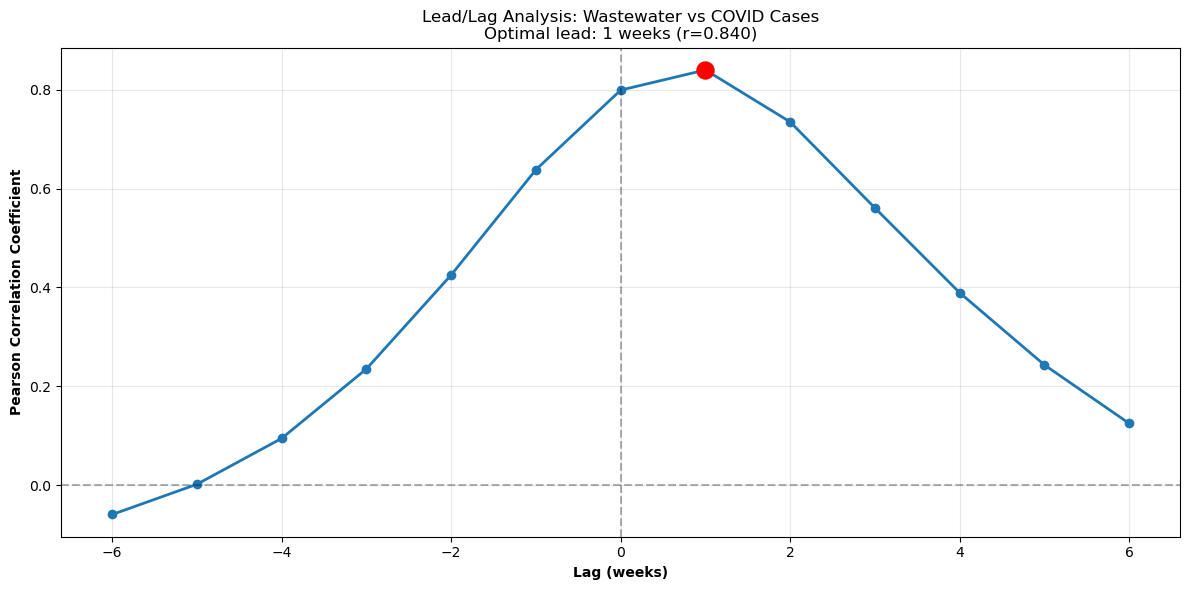

In [28]:
# Visualization: Lead/Lag Correlation Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(lag_df['lag_weeks'], lag_df['correlation'], 'o-', linewidth=2, markersize=6)
ax.scatter([optimal_lag], [optimal_corr], color='red', s=150, zorder=5)
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.axvline(0, color='black', linestyle='--', alpha=0.3)

ax.set_xlabel('Lag (weeks)', fontweight='bold')
ax.set_ylabel('Pearson Correlation Coefficient', fontweight='bold')
ax.set_title(f'Lead/Lag Analysis: Wastewater vs COVID Cases\n'
             f'Optimal lead: {abs(optimal_lag)} weeks (r={optimal_corr:.3f})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


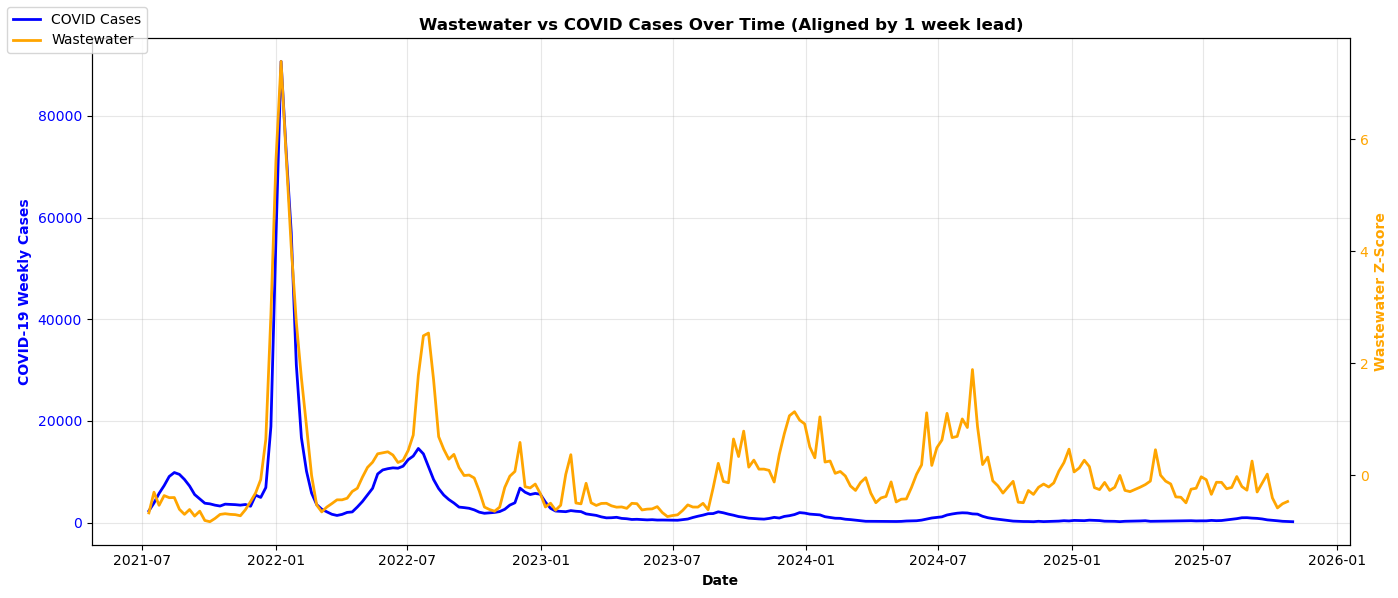

In [29]:
# Visualization: Time Series Overlay
# Shift wastewater by optimal lag to align with COVID cases
merged['wastewater_aligned'] = merged['wastewater_zscore'].shift(-optimal_lag)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('COVID-19 Weekly Cases', color='blue', fontweight='bold')
line1 = ax1.plot(merged['WkEndActual'], merged['Cases'], color='blue', linewidth=2, label='COVID Cases')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Wastewater Z-Score', color='orange', fontweight='bold')
line2 = ax2.plot(merged['WkEndActual'], merged['wastewater_aligned'], color='orange', linewidth=2, label='Wastewater')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.set_title(f'Wastewater vs COVID Cases Over Time (Aligned by {abs(optimal_lag)} week lead)', fontweight='bold')
ax1.grid(True, alpha=0.3)
fig.legend(loc='upper left')

plt.tight_layout()
plt.show()


Let's also analyze how the correlation between wastewater and COVID cases changes over time using an 8-week rolling window during peak transmission period (Nov 2021 - Nov 2022). In epidemiological data analytics, this type of correlation over a specific window has also been called **Rolling Window Dynamic Correlation**

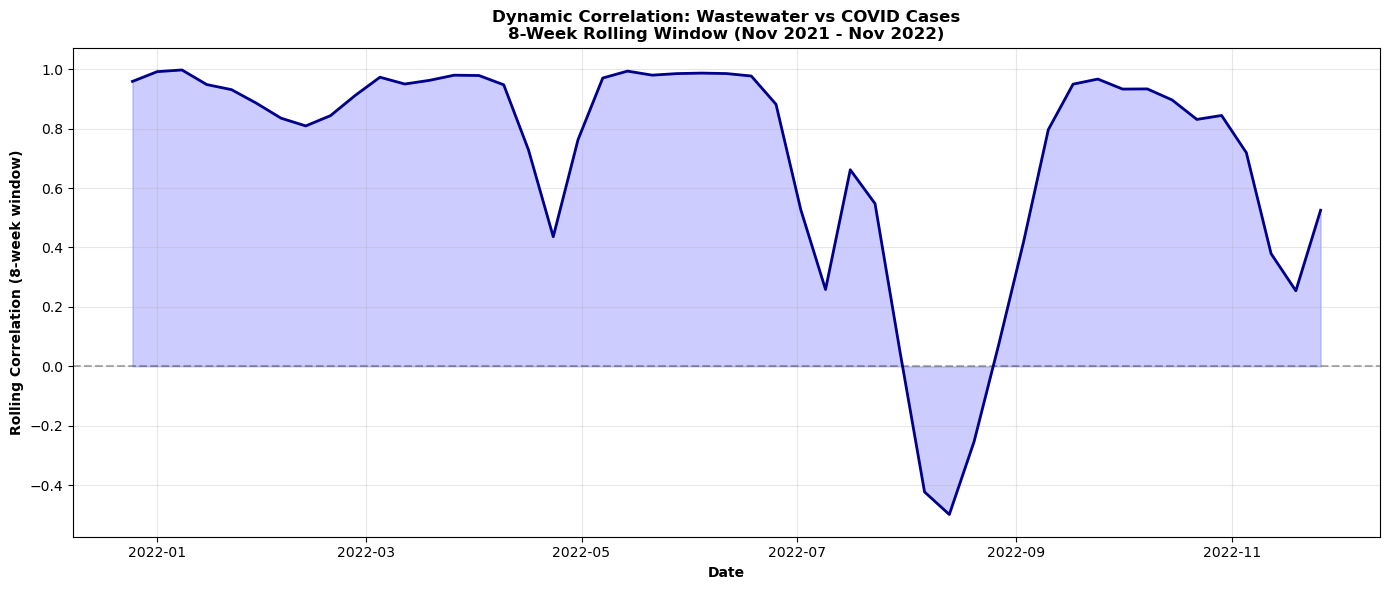

In [30]:
# Filter data to peak period: Nov 2021 - Nov 2022
start_date = pd.Timestamp('2021-11-01')
end_date = pd.Timestamp('2022-11-30')
peak_data = merged[(merged['WkEndActual'] >= start_date) & (merged['WkEndActual'] <= end_date)].copy()
peak_data = peak_data.sort_values('WkEndActual').reset_index(drop=True)

# Calculate 8-week rolling correlation
window_size = 8
rolling_corr = []
for i in range(len(peak_data)):
    if i >= window_size - 1:
        window_df = peak_data.iloc[i-window_size+1:i+1]
        valid = window_df[['wastewater_zscore', 'Cases']].dropna()
        if len(valid) >= 6:
            corr, _ = pearsonr(valid['wastewater_zscore'], valid['Cases'])
            rolling_corr.append(corr)
        else:
            rolling_corr.append(np.nan)
    else:
        rolling_corr.append(np.nan)

peak_data['rolling_corr'] = rolling_corr

# Plot rolling correlation over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(peak_data['WkEndActual'], peak_data['rolling_corr'], linewidth=2, color='darkblue')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.fill_between(peak_data['WkEndActual'], peak_data['rolling_corr'], 0, alpha=0.2, color='blue')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Rolling Correlation (8-week window)', fontweight='bold')
ax.set_title('Dynamic Correlation: Wastewater vs COVID Cases\n8-Week Rolling Window (Nov 2021 - Nov 2022)', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This is an interesting insight. If we drive back to the past, we remember that the Omicron Variant (B.1.1.529) - first identified in Nov 2021 - quickly became the dominant variant due to its extremely high transmissibility and ability to evade some vaccine immunity! 

**Reference-**

Cutrupi, F., Cadonna, M., Manara, S., Postinghel, M., La Rosa, G., Suffredini, E., & Foladori, P. (2022). *The wave of the SARS-CoV-2 Omicron variant resulted in a rapid spike and decline as highlighted by municipal wastewater surveillance.* Environmental Technology & Innovation, 28, 102667. https://doi.org/10.1016/j.eti.2022.102667


### Scatter Matrix with Regression Analysis

Quantify relationships between wastewater z-scores and different COVID metrics (Cases, Hospitalizations, Deaths) with regression lines and statistical measures.

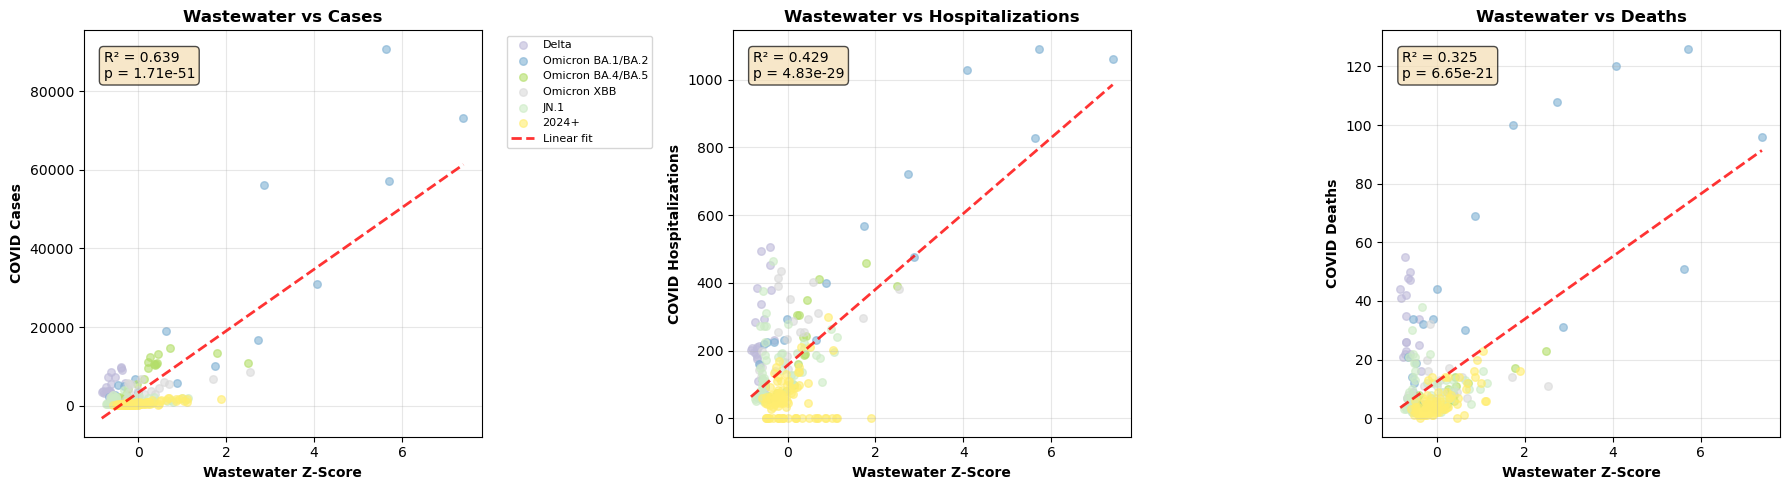

In [31]:
# Prepare data with pandemic wave labels
def assign_wave(date):
    if date < pd.Timestamp('2021-07-01'):
        return 'Pre-Delta'
    elif date < pd.Timestamp('2021-12-01'):
        return 'Delta'
    elif date < pd.Timestamp('2022-04-01'):
        return 'Omicron BA.1/BA.2'
    elif date < pd.Timestamp('2022-08-01'):
        return 'Omicron BA.4/BA.5'
    elif date < pd.Timestamp('2023-01-01'):
        return 'Omicron XBB'
    elif date < pd.Timestamp('2024-01-01'):
        return 'JN.1'
    else:
        return '2024+'

merged_with_waves = merged.copy()
merged_with_waves['wave'] = merged_with_waves['WkEndActual'].apply(assign_wave)
merged_with_waves = merged_with_waves.merge(
    covid[['WkEndActual', 'Hospitalization', 'Deaths']],
    on='WkEndActual',
    how='left'
)

plot_data = merged_with_waves[['wastewater_zscore', 'Cases', 'Hospitalization', 'Deaths', 'wave']].dropna()
wave_order = ['Pre-Delta', 'Delta', 'Omicron BA.1/BA.2', 'Omicron BA.4/BA.5', 'Omicron XBB', 'JN.1', '2024+']
wave_colors = plt.cm.Set3(np.linspace(0, 1, len(wave_order)))
wave_color_map = dict(zip(wave_order, wave_colors))

# Create scatter plots with regression
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['Cases', 'Hospitalization', 'Deaths']
metrics_labels = ['Cases', 'Hospitalizations', 'Deaths']

for idx, (metric, label) in enumerate(zip(metrics, metrics_labels)):
    ax = axes[idx]
    
    # Plot scatter points colored by wave
    for wave in wave_order:
        wave_data = plot_data[plot_data['wave'] == wave]
        if len(wave_data) > 0:
            ax.scatter(wave_data['wastewater_zscore'], wave_data[metric], 
          color=wave_color_map[wave], label=wave, alpha=0.6, s=30)
    
    # Fit linear regression
    valid = plot_data[['wastewater_zscore', metric]].dropna()
    if len(valid) > 10:
        z = np.polyfit(valid['wastewater_zscore'], valid[metric], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid['wastewater_zscore'].min(), valid['wastewater_zscore'].max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Linear fit')
        
        # Calculate R² and p-value
        y_pred = p(valid['wastewater_zscore'])
        y_mean = valid[metric].mean()
        ss_res = ((valid[metric] - y_pred) ** 2).sum()
        ss_tot = ((valid[metric] - y_mean) ** 2).sum()
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        corr, pval = pearsonr(valid['wastewater_zscore'], valid[metric])
        
        # Add text annotation
        ax.text(0.05, 0.95, f'R² = {r2:.3f}\np = {pval:.2e}', 
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax.set_xlabel('Wastewater Z-Score', fontweight='bold')
    ax.set_ylabel(f'COVID {label}', fontweight='bold')
    ax.set_title(f'Wastewater vs {label}', fontweight='bold')
    ax.grid(True, alpha=0.3)

axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


Inferences & Practical importance of Scatter Matrix Regression Analysis:
+ *Cases*: R² = 0.639 (strongest correlation) - Wastewater is an excellent predictor of case counts
+ *Hospitalizations*: R² = 0.429 (moderate correlation) - Wastewater moderately predicts hospitalizations
+ *Deaths*: R² = 0.325 (weakest correlation) - Wastewater has limited predictive power for deaths

All relationships are statistically significant (p < e^-20), confirming real associations. To summarize, Wastewater surveillance is most valuable as an early warning system for case surges, but should be combined with demographic and clinical data to predict hospitalizations and deaths.

# Phase 2: Weather correlation with COVID-19 transmission

In this part, we shall examine how temperature affects COVID-19 case rates to identify optimal temperature ranges for transmission.

In [32]:
# Load weather data and prepare for analysis
weather = pd.read_csv("./Data_wrangling/weather_Point Loma.csv")
weather['date'] = pd.to_datetime(weather['date']).dt.tz_localize(None)
weather['avg_temp'] = (weather['max_temp_c'] + weather['min_temp_c']) / 2
weather = weather.set_index('date').sort_index()

# Aggregate daily weather to weekly averages aligned with COVID weeks
weekly_weather = []
for _, row in covid.iterrows():
    week_start = row['Wk Start']
    week_end = row['WkEndActual']
    mask = (weather.index >= week_start) & (weather.index <= week_end)
    week_data = weather.loc[mask, 'avg_temp']
    if len(week_data) > 0:
        weekly_weather.append({
            'WkEndActual': week_end,
            'avg_temp': week_data.mean()
        })

weather_weekly = pd.DataFrame(weekly_weather)

# Merge weather with COVID data (using case rate)
covid_with_rates = covid[['WkEndActual', 'Case Rate (per 100K)']].copy()
temp_covid = pd.merge(
    covid_with_rates,
    weather_weekly,
    on='WkEndActual',
    how='inner'
)
temp_covid['month'] = pd.to_datetime(temp_covid['WkEndActual']).dt.month
temp_covid = temp_covid.dropna()


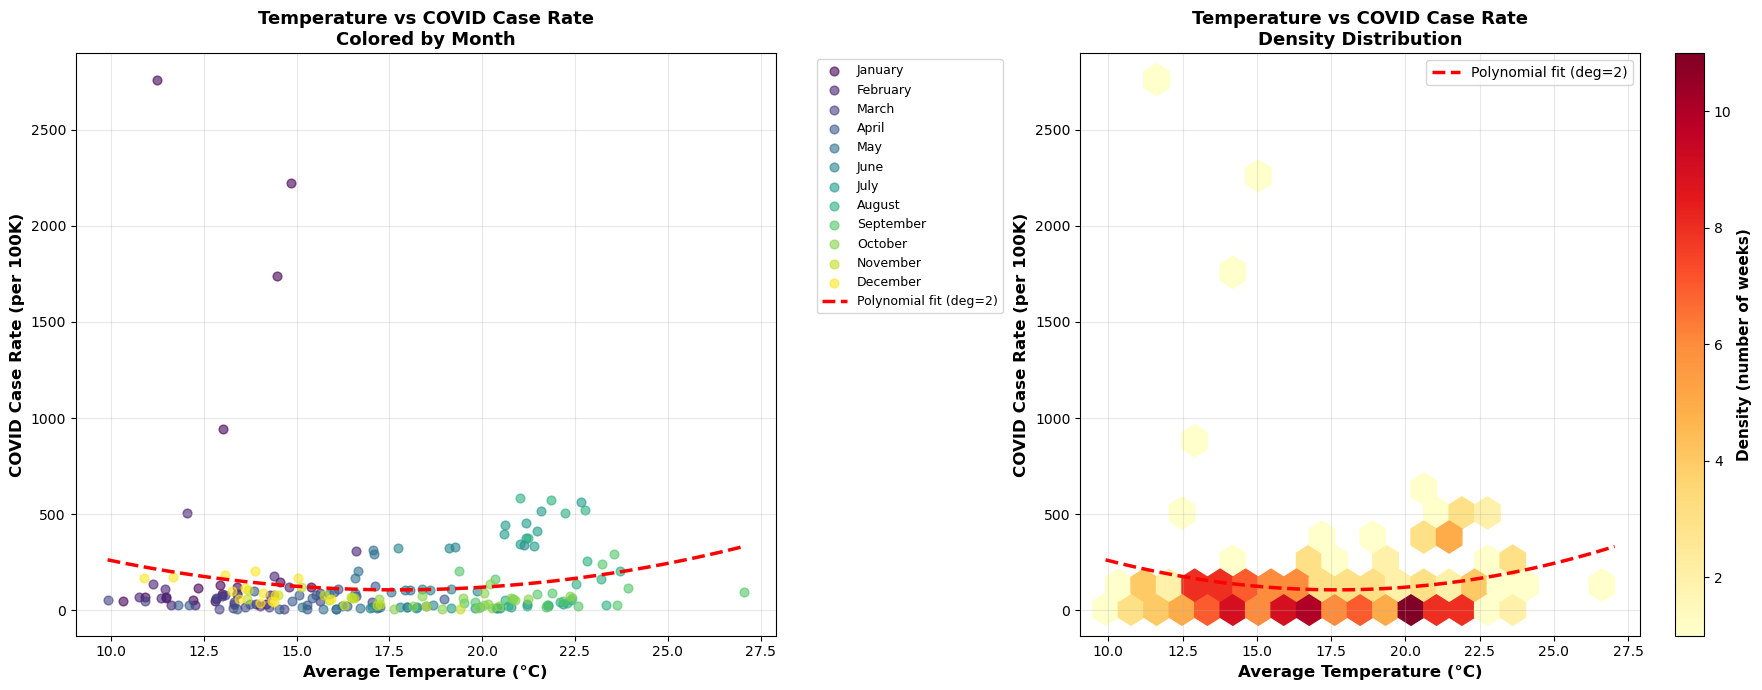

Temperature vs Case Rate correlation: r = -0.0221 (p = 7.5647e-01)

Polynomial fit suggests minimum case rate at: 17.7°C
Predicted case rate at minimum: 106.2 per 100K


In [33]:
# Create visualization with scatter, hexbin, and polynomial regression
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Scatter plot colored by month
ax1 = axes[0]
months = sorted(temp_covid['month'].unique())
month_colors = plt.cm.viridis(np.linspace(0, 1, len(months)))
month_color_map = dict(zip(months, month_colors))

for month in months:
    month_data = temp_covid[temp_covid['month'] == month]
    if len(month_data) > 0:
        month_name = pd.Timestamp(2022, month, 1).strftime('%B')
        ax1.scatter(month_data['avg_temp'], month_data['Case Rate (per 100K)'],
                   color=month_color_map[month], label=month_name, alpha=0.6, s=40)

# Fit polynomial regression (degree 2)
x = temp_covid['avg_temp'].values
y = temp_covid['Case Rate (per 100K)'].values
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_line, p(x_line), "r--", linewidth=2.5, label='Polynomial fit (deg=2)', zorder=5)

ax1.set_xlabel('Average Temperature (°C)', fontweight='bold', fontsize=12)
ax1.set_ylabel('COVID Case Rate (per 100K)', fontweight='bold', fontsize=12)
ax1.set_title('Temperature vs COVID Case Rate\nColored by Month', fontweight='bold', fontsize=13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)
ax1.grid(True, alpha=0.3)

# Right plot: Hexbin density plot
ax2 = axes[1]
hb = ax2.hexbin(temp_covid['avg_temp'], temp_covid['Case Rate (per 100K)'],
                gridsize=20, cmap='YlOrRd', mincnt=1)
cb = plt.colorbar(hb, ax=ax2)
cb.set_label('Density (number of weeks)', fontsize=11, fontweight='bold')

# Overlay polynomial regression on hexbin plot
ax2.plot(x_line, p(x_line), "r--", linewidth=2.5, label='Polynomial fit (deg=2)', zorder=5)

ax2.set_xlabel('Average Temperature (°C)', fontweight='bold', fontsize=12)
ax2.set_ylabel('COVID Case Rate (per 100K)', fontweight='bold', fontsize=12)
ax2.set_title('Temperature vs COVID Case Rate\nDensity Distribution', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation and find optimal temperature
corr_temp, pval_temp = pearsonr(temp_covid['avg_temp'], temp_covid['Case Rate (per 100K)'])
print(f"Temperature vs Case Rate correlation: r = {corr_temp:.4f} (p = {pval_temp:.4e})")

# Find temperature with minimum case rate (from polynomial fit vertex)
x_min = -z[1] / (2 * z[0])  # Vertex of quadratic (minimum for U-shaped curve)
min_case_rate = p(x_min)
print(f"\nPolynomial fit suggests minimum case rate at: {x_min:.1f}°C")
print(f"Predicted case rate at minimum: {min_case_rate:.1f} per 100K")


Inferences & Practical importance of Weather/seasonal correlation with covid transmission:
+ Winter months (Jan-Mar, 11-15 degrees ~avg): Highest case rates observed (some exceeding 2500 per 100K) - indoor crowding, reduced ventilation, increased susceptibility during cold season. Mild temperatures (15-22 degrees ~avg) are most optimal with lower case rates.

As a conclusion, we propose that weather alone is not the primary driver - The weak correlations suggests temperature is just one of many factors (the rest being behavior, immunity, variants, etc.)

# Phase 3: Combined Analysis: Wastewater, Weather, and COVID-19

In this part, we attempt to explore relationships between all three factors together. Note that from the phase 2 observation- Temperature shows weak individual correlation, but combining factors may reveal synergistic effects. Let's see the correlation matrix first

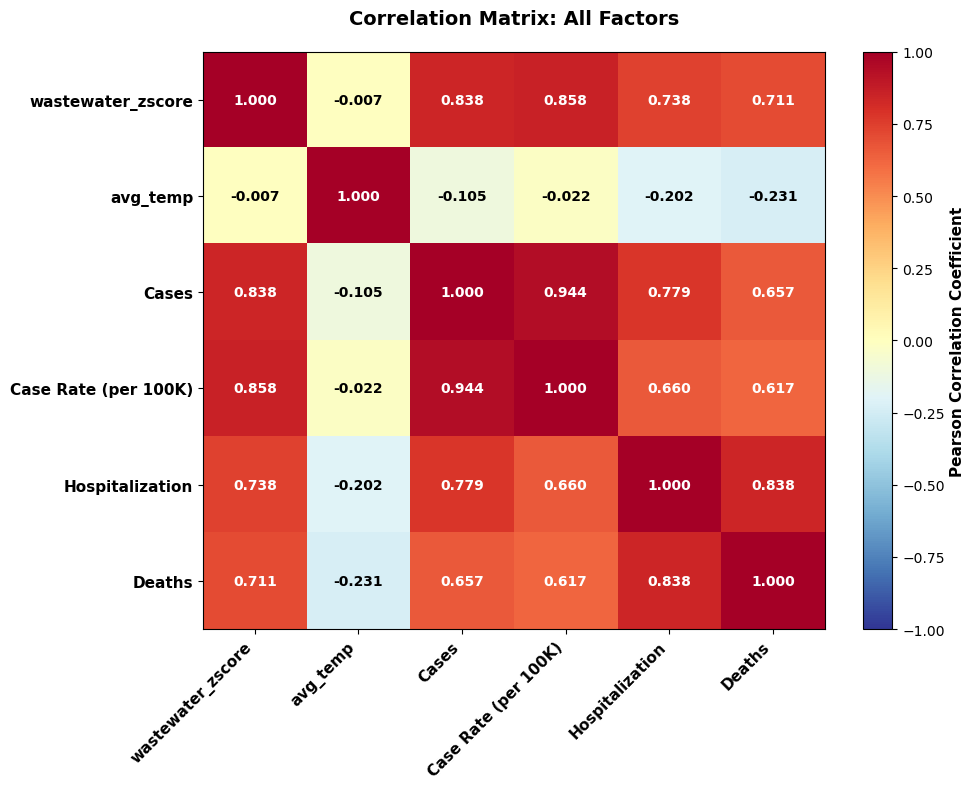

In [34]:
# The correlation matrix construction
# Prepare data with all three factors
combined_data = merged[['WkEndActual', 'wastewater_zscore', 'Cases']].copy()
combined_data = combined_data.merge(
    weather_weekly[['WkEndActual', 'avg_temp']],
    on='WkEndActual',
    how='inner'
)
combined_data = combined_data.merge(
    covid[['WkEndActual', 'Case Rate (per 100K)', 'Hospitalization', 'Deaths']],
    on='WkEndActual',
    how='left'
)
combined_data = combined_data.dropna(subset=['wastewater_zscore', 'avg_temp', 'Cases'])

# Create correlation matrix
corr_vars = ['wastewater_zscore', 'avg_temp', 'Cases', 'Case Rate (per 100K)', 'Hospitalization', 'Deaths']
corr_matrix = combined_data[corr_vars].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1, aspect='auto')

# Add correlation values as text
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        text_color = 'white' if abs(value) > 0.5 else 'black'
        ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
               color=text_color, fontweight='bold', fontsize=10)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontweight='bold', fontsize=11)
ax.set_yticklabels(corr_matrix.columns, fontweight='bold', fontsize=11)
ax.set_title('Correlation Matrix: All Factors', fontweight='bold', fontsize=14, pad=20)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Pearson Correlation Coefficient', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


##### Key insight!! Observe that Wastewater correlations (0.71–0.86) are highly significant and practically meaningful. On the other hand, temperature correlations (-0.23 to -0.02) are too weak to be useful for prediction. Hence, we can safely conclude that for future resource allocation, wastewater trends can be useful to forecast hospital bed needs or covid-related death trends!

#### Triple-Axis Time Series Curve fit

Visualize wastewater, temperature, and COVID cases simultaneously to observe synchronized patterns.

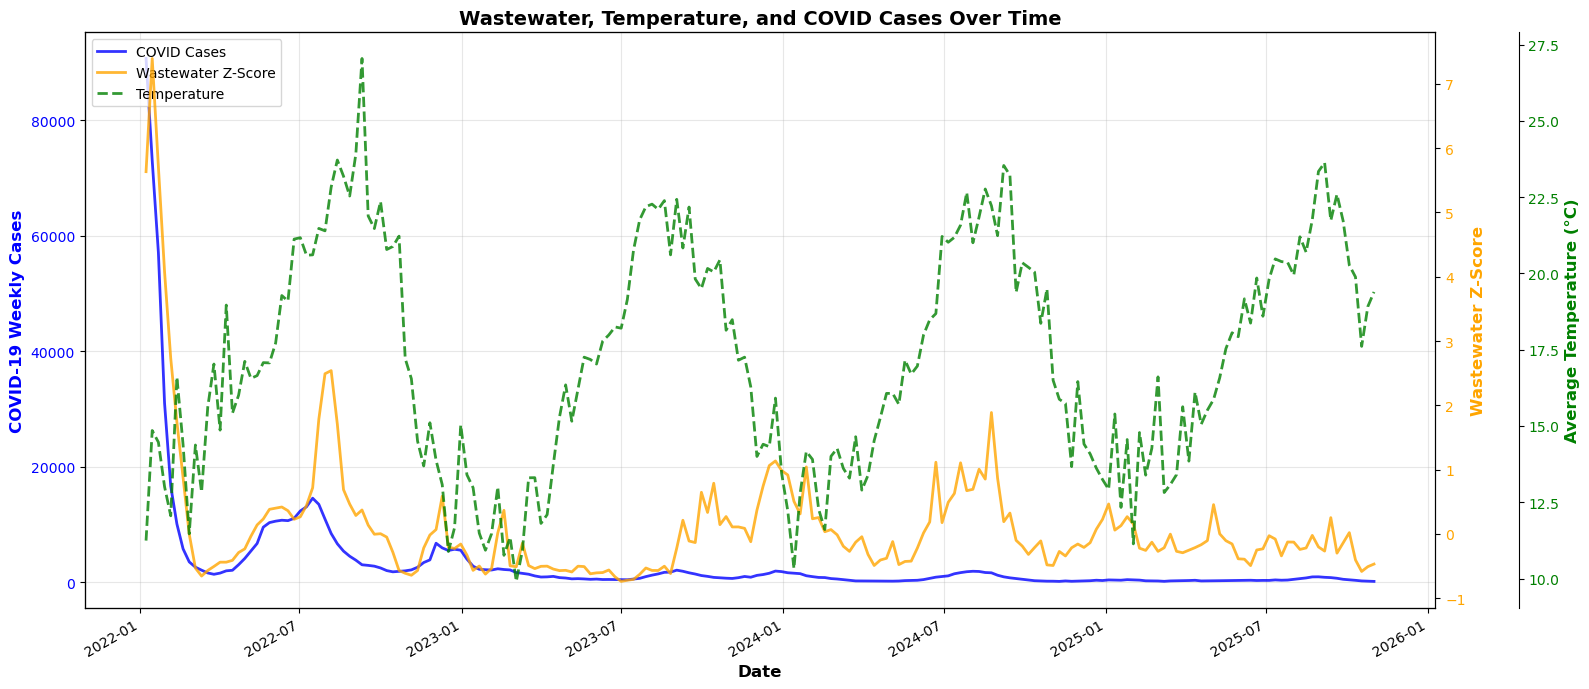

In [35]:
# Create triple-axis time series plot
fig, ax1 = plt.subplots(figsize=(16, 7))

# Left y-axis: COVID Cases
color1 = 'blue'
ax1.set_xlabel('Date', fontweight='bold', fontsize=12)
ax1.set_ylabel('COVID-19 Weekly Cases', color=color1, fontweight='bold', fontsize=12)
line1 = ax1.plot(combined_data['WkEndActual'], combined_data['Cases'], 
                color=color1, linewidth=2, label='COVID Cases', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)

# Right y-axis 1: Wastewater z-score
ax2 = ax1.twinx()
color2 = 'orange'
ax2.set_ylabel('Wastewater Z-Score', color=color2, fontweight='bold', fontsize=12)
line2 = ax2.plot(combined_data['WkEndActual'], combined_data['wastewater_zscore'], 
                color=color2, linewidth=2, label='Wastewater Z-Score', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2)

# Right y-axis 2: Temperature (offset)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color3 = 'green'
ax3.set_ylabel('Average Temperature (°C)', color=color3, fontweight='bold', fontsize=12)
line3 = ax3.plot(combined_data['WkEndActual'], combined_data['avg_temp'], 
                color=color3, linewidth=2, label='Temperature', alpha=0.8, linestyle='--')
ax3.tick_params(axis='y', labelcolor=color3)

ax1.set_title('Wastewater, Temperature, and COVID Cases Over Time', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()
